# Lead Segmentation

In [1]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt
import random

NUM_IMAGES = 20
CONF_THRESHOLD = 0.7

TEST_IMAGE_DIR = '../data/clean-ecg-6by2'
SAVE_ROOT =   '../data/final-outputs'
MODEL_PATH = '../models/yolo-segmentation-weights.pt'

# Load model
model = YOLO(MODEL_PATH)

# Read image files
image_files = [f for f in os.listdir(TEST_IMAGE_DIR) if f.endswith((".jpg", ".png"))]
os.makedirs(SAVE_ROOT, exist_ok=True)

# Mapping from class ID to name
class_names = model.names

LEFT_LABELS = ['I', 'II', 'III', 'aVL', 'aVR', 'aVF']
RIGHT_LABELS = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']


In [2]:
def sort_wave_boxes(boxes, row_threshold=30):
    """
    Sorts boxes in row-major order (top-to-bottom, left-to-right), robust to overlaps.
    Each box: [x1, y1, x2, y2]
    row_threshold: max vertical distance between centers to consider boxes in the same row.
    """
    # Compute vertical centers
    boxes_with_centers = []
    for box in boxes:
        x1, y1, x2, y2 = box
        y_center = (y1 + y2) / 2
        x_center = (x1 + x2) / 2
        boxes_with_centers.append((box, y_center, x_center))

    # Sort by y_center
    boxes_with_centers.sort(key=lambda b: b[1])

    # Group into rows
    rows = []
    for box, y_center, x_center in boxes_with_centers:
        placed = False
        for row in rows:
            # If y_center is close to the first box in the row, add to this row
            if abs(row[0][1] - y_center) < row_threshold:
                row.append((box, y_center, x_center))
                placed = True
                break
        if not placed:
            rows.append([(box, y_center, x_center)])

    # Sort each row by x_center
    for row in rows:
        row.sort(key=lambda b: b[2])

    # Flatten rows
    sorted_boxes = [b[0] for row in rows for b in row]
    return sorted_boxes

for idx in range(15):
    image_file = random.choice(image_files)
    image_path = os.path.join(TEST_IMAGE_DIR, image_file)
    base_name = os.path.splitext(image_file)[0]

    # Inference
    results = model(image_path)[0]

    # Read and prepare image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

    # Get class 0 boxes above threshold
    wave_boxes = []
    for box in results.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if conf >= CONF_THRESHOLD and cls_id == 0:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            wave_boxes.append([x1, y1, x2, y2])

    # --- Robust labeling: split into left/right, sort by y, assign labels ---
    if len(wave_boxes) >= 12:
        # Compute x-centers
        x_centers = [((box[0] + box[2]) / 2) for box in wave_boxes]
        median_x = np.median(x_centers)

        left_boxes = []
        right_boxes = []
        for box in wave_boxes:
            x_center = (box[0] + box[2]) / 2
            if x_center < median_x:
                left_boxes.append(box)
            else:
                right_boxes.append(box)

        # Sort each group by y-center (top to bottom)
        left_boxes = sorted(left_boxes, key=lambda b: (b[1] + b[3]) / 2)
        right_boxes = sorted(right_boxes, key=lambda b: (b[1] + b[3]) / 2)

        # Assign labels
        labeled_boxes = []
        for box, label in zip(left_boxes, LEFT_LABELS):
            labeled_boxes.append((box, label))
        for box, label in zip(right_boxes, RIGHT_LABELS):
            labeled_boxes.append((box, label))

        # # Plot full image
        # plt.figure(figsize=(6, 6))
        # plt.imshow(img_rgb)
        # plt.title("Full Image")
        # plt.axis('off')
        # plt.show()

        # # Plot each cropped lead as a separate plot with correct label
        # for box, label in labeled_boxes:
        #     x1, y1, x2, y2 = box
        #     crop = img_rgb[y1:y2, x1:x2]
        #     plt.figure(figsize=(6, 6))
        #     plt.imshow(crop)
        #     plt.title(label)
        #     plt.axis('off')
        #     plt.show()
    else:
        print("Not enough boxes detected for robust labeling.")

    # Save each cropped lead with its label
    for box, label in labeled_boxes:
        x1, y1, x2, y2 = box
        crop = img[y1:y2, x1:x2]  # Use original BGR image for saving
        save_path = os.path.join(SAVE_ROOT, f"{base_name}_{label}.jpg")
        cv2.imwrite(save_path, crop, [cv2.IMWRITE_JPEG_QUALITY, 100])

    # Save the full image with rectangles and labels
    annotated = img_rgb.copy()
    for box, label in labeled_boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated, label, (x1, max(y1 - 10, 10)), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
        full_save_path = os.path.join(SAVE_ROOT, f"{base_name}_full.jpg")
        cv2.imwrite(full_save_path, cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 100])


image 1/1 /home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../data/clean-ecg-6by2/254_6by2.jpg: 320x640 13 lead_containers, 1 label_II, 1 label_III, 1 label_aVR, 1 label_aVL, 1 label_aVF, 1 label_V1, 1 label_V2, 1 label_V3, 1 label_V4, 1 label_V5, 1 label_V6, 1106.8ms
Speed: 35.6ms preprocess, 1106.8ms inference, 129.2ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../data/clean-ecg-6by2/466_6by2.jpg: 320x640 13 lead_containers, 1 label_II, 1 label_III, 1 label_aVR, 1 label_aVL, 1 label_aVF, 1 label_V1, 1 label_V2, 1 label_V3, 1 label_V4, 1 label_V5, 1 label_V6, 240.7ms
Speed: 2.2ms preprocess, 240.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../data/clean-ecg-6by2/362_6by2.jpg: 320x640 13 lead_containers, 1 label_II, 1 label_III, 1 label_aVR, 1 label_aVL, 1 label_aVF, 1 label_V1, 1 label_V2, 1 label_V3, 1 label_V4, 

# Grid Seperation

In [3]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from glob import glob

In [4]:

def extract_grid_mask(img, closing_kernel=5, length_frac=0.8):
    """
    img:       BGR or grayscale input
    closing_kernel: size of small kernel to close grid dots ([3,3] works well)
    length_frac: fraction of img width/height that a line must span to be kept
    """
    # 1) Grayscale + adaptive threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim==3 else img
    binarized = cv2.adaptiveThreshold(gray,255,
                                      cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY_INV,
                                      blockSize=11, C=5)

    # 2) Close gaps (connect dots into lines)
    kernel_close = np.ones((closing_kernel, closing_kernel), np.uint8)
    closed = cv2.morphologyEx(binarized, cv2.MORPH_CLOSE, kernel_close)

    h, w = gray.shape

    # 3a) Extract horizontal lines via opening
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(w*1), 1))
    horiz_lines = cv2.morphologyEx(closed, cv2.MORPH_OPEN, horiz_kernel)

    # 3b) Extract vertical lines via opening
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(h*0.5)))
    vert_lines = cv2.morphologyEx(closed, cv2.MORPH_OPEN, vert_kernel)

    # 4) Filter by length: remove any connected component shorter than threshold
    def filter_by_length(mask, axis_len):
        # keep only components whose bounding‐box along axis >= length_frac*axis_len
        nb_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        out = np.zeros_like(mask)
        min_len = length_frac * axis_len
        for i in range(1, nb_components):
            x, y, w0, h0, area = stats[i]
            if axis_len==w:    # horizontal mask
                if w0 >= min_len:
                    out[labels==i] = 255
            else:              # vertical mask
                if h0 >= min_len:
                    out[labels==i] = 255
        return out

    horiz_clean = filter_by_length(horiz_lines, w)
    vert_clean  = filter_by_length(vert_lines,  h)

    # 5) Combine
    grid_mask = cv2.bitwise_or(horiz_clean, vert_clean)
    return grid_mask


def visualize(image, grid_mask):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[1].imshow(grid_mask, cmap='gray')
    axs[1].set_title("Detected Grid")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
import os
import random

IMAGE_DIR = '../data/final-outputs'

img_paths = []
for fname in os.listdir(IMAGE_DIR):
    fname_lower = fname.lower()
    if (
        fname_lower.endswith(('.png', '.jpg', '.jpeg')) and
        'full' not in fname_lower and
        'grid' not in fname_lower and
        'wave' not in fname_lower and
        'waveform' not in fname_lower
    ):
        img_paths.append(os.path.join(IMAGE_DIR, fname))

sample_paths = random.sample(img_paths, min(15, len(img_paths)))

In [6]:
img_paths[1]

'../data/final-outputs/1110_6by2_aVL.jpg'

In [7]:
len(img_paths)

132

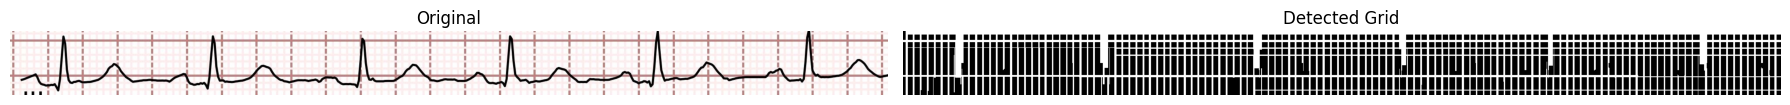

Estimated square width:  16 px (count=64)
Estimated square height: 17 px (count=2)
Selected square size:  80 px


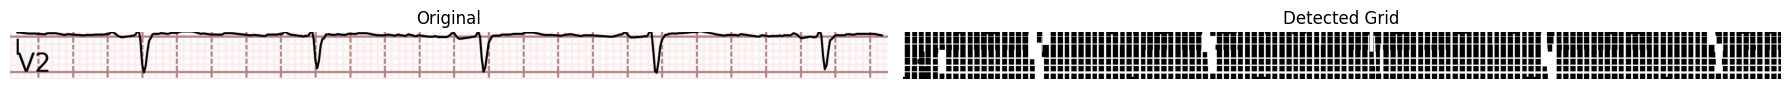

Estimated square width:  16 px (count=69)
Estimated square height: 17 px (count=2)
Selected square size:  80 px


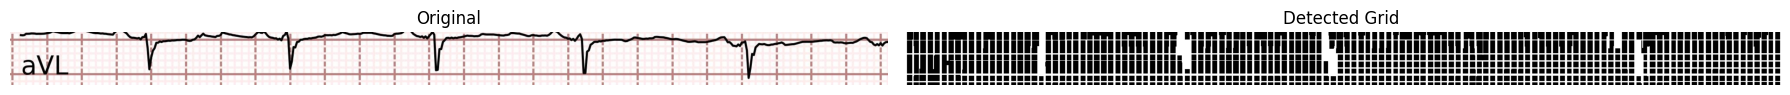

Estimated square width:  16 px (count=58)
Estimated square height: 16 px (count=2)
Selected square size:  80 px


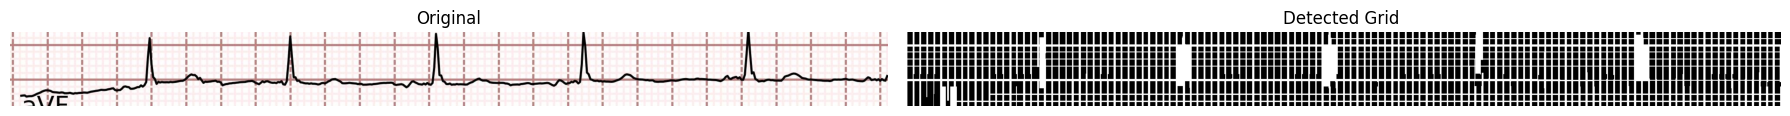

Estimated square width:  16 px (count=66)
Estimated square height: 16 px (count=6)
Selected square size:  80 px


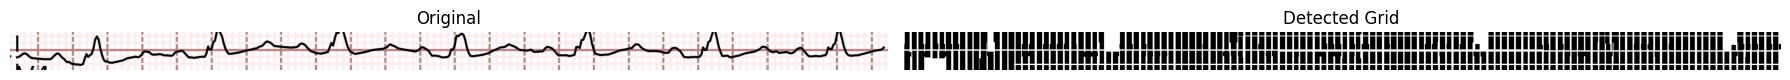

Estimated square width:  16 px (count=60)
Estimated square height: 31 px (count=1)
Selected square size:  80 px


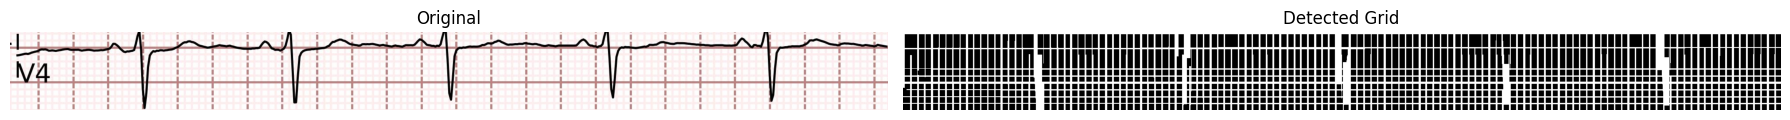

Estimated square width:  16 px (count=73)
Estimated square height: 15 px (count=3)
Selected square size:  80 px


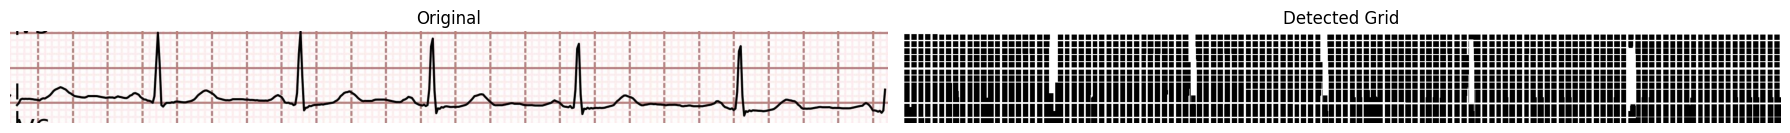

Estimated square width:  16 px (count=74)
Estimated square height: 16 px (count=5)
Selected square size:  80 px


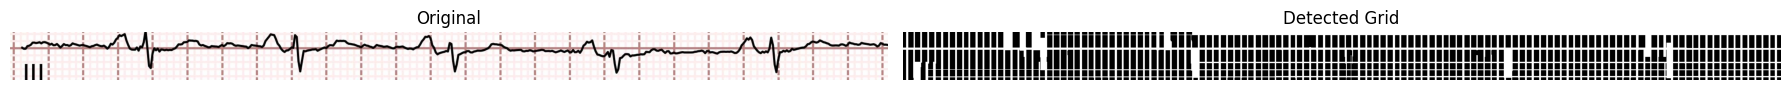

Estimated square width:  16 px (count=80)
Estimated square height: 16 px (count=2)
Selected square size:  80 px


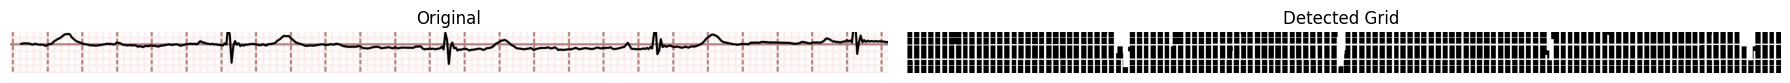

Estimated square width:  16 px (count=82)
Estimated square height: 16 px (count=3)
Selected square size:  80 px


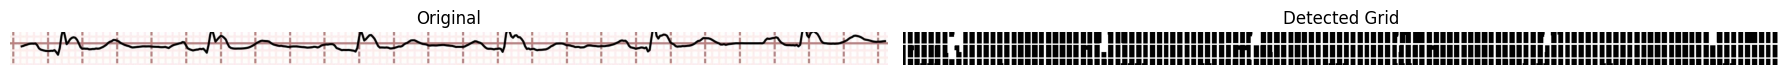

Estimated square width:  16 px (count=68)
Estimated square height: 16 px (count=1)
Selected square size:  80 px


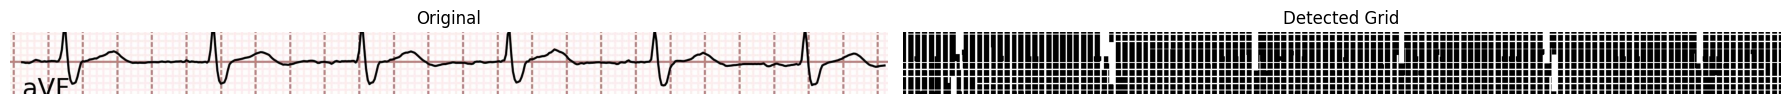

Estimated square width:  16 px (count=70)
Estimated square height: 16 px (count=3)
Selected square size:  80 px


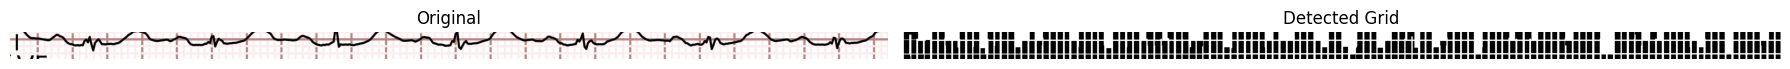

Estimated square width:  16 px (count=76)
Estimated square height: 16 px (count=1)
Selected square size:  80 px


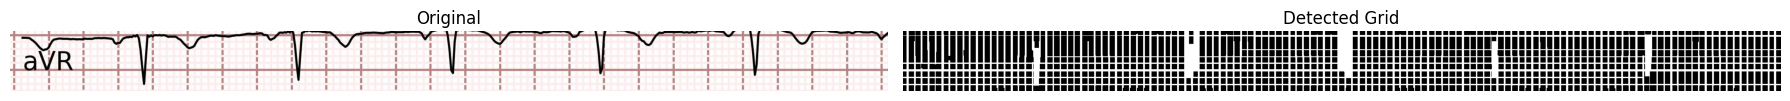

Estimated square width:  16 px (count=65)
Estimated square height: 16 px (count=3)
Selected square size:  80 px


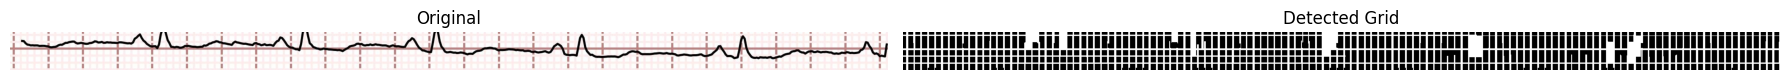

Estimated square width:  16 px (count=70)
Estimated square height: 17 px (count=1)
Selected square size:  80 px


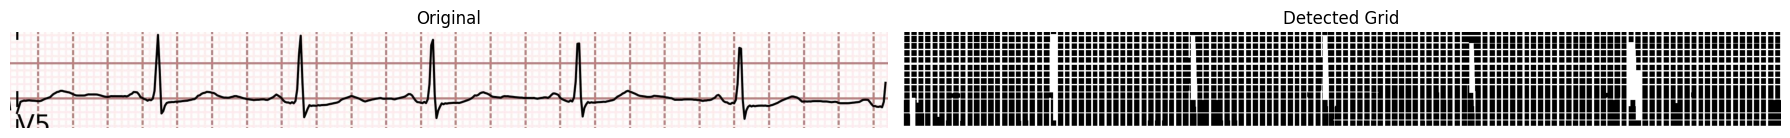

Estimated square width:  16 px (count=78)
Estimated square height: 16 px (count=5)
Selected square size:  80 px


In [8]:
from scipy.signal import find_peaks

images = []
masks = []
sizes = []
orig_names = []

for path in sample_paths:
    img = cv2.imread(path)
    if img is None:
        continue
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img_gray)
    orig_names.append(os.path.basename(path))
    grid_mask = extract_grid_mask(img, closing_kernel=10, length_frac=0.05)
    masks.append(grid_mask)

    # Save grid mask in the same folder as the original image
    save_dir = os.path.dirname(path)
    orig_base, orig_ext = os.path.splitext(os.path.basename(path))
    grid_mask_name = f"{orig_base}_grid{orig_ext}"

    # Visualization
    visualize(img, grid_mask)

    # 1) Project onto each axis
    vertical_profile   = grid_mask.sum(axis=0)   # sum over rows → strong peaks at vertical lines
    horizontal_profile = grid_mask.sum(axis=1)   # sum over cols → strong peaks at horizontal lines

    # 2) Find the line positions (peaks)
    #    height thresholds assume lines span most of the image
    v_peaks, _ = find_peaks(vertical_profile, height=grid_mask.shape[0] * 0.5)
    h_peaks, _ = find_peaks(horizontal_profile, height=grid_mask.shape[1] * 0.5)

    # 3) Compute spacings between consecutive peaks
    v_spacings = np.diff(v_peaks)   # pixel widths between vertical lines
    h_spacings = np.diff(h_peaks)   # pixel heights between horizontal lines

    # 4) Get mode with tiebreaker (highest)
    def mode_with_tiebreak(data):
        if len(data) == 0:
            return None, 0
        vals, counts = np.unique(data, return_counts=True)
        max_count = counts.max()
        candidates = vals[counts == max_count]
        return candidates.max(), max_count  # highest value among ties + its frequency

    # Get mode values and their frequencies
    avg_square_width,  count_w = mode_with_tiebreak(v_spacings)
    avg_square_height, count_h = mode_with_tiebreak(h_spacings)

    # Decide final square size based on higher frequency
    if count_w > count_h:
        square_size = avg_square_width
    elif count_h > count_w:
        square_size = avg_square_height
    else:
        square_size = max(avg_square_width, avg_square_height)  # tie → choose bigger

    if max(count_h, count_w) > 40: #if there are too many squares then the small squares are being detetcted:
        square_size *= 5

    # Append and print
    sizes.append(square_size)
    print(f"Estimated square width:  {avg_square_width} px (count={count_w})")
    print(f"Estimated square height: {avg_square_height} px (count={count_h})")
    print(f"Selected square size:  {square_size} px")

    orig_base, orig_ext = os.path.splitext(os.path.basename(path))
    grid_mask_name = f"{orig_base}_grid{orig_ext}"
    size_name = f"{orig_base}_size.txt"
    cv2.imwrite(os.path.join(save_dir, grid_mask_name), grid_mask)
    with open(os.path.join(save_dir, size_name), 'w') as f:
        f.write(str(square_size))


# Extract Binary Mask

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from segmentation_models_pytorch import Unet
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2

/home/abdullah-bin-mansoor/Desktop/ECG Project/ecg_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import sys
sys.path.append('../wave-binary-mask/scripts')

from ecg_dataset import ECGDataset


In [11]:
# === Paths ===
WEIGHTS_PATH = '../models/unet-binary-masking.pth'  # Update if needed
IMAGE_DIR = '../data/final-outputs'
SAVE_DIR = '../data/final-outputs'
os.makedirs(SAVE_DIR, exist_ok=True)

# === Constants ===
BATCH_SIZE = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# === Load dataset ===
masks = []
valid_images = sample_paths

test_ds = ECGDataset(sample_paths, mask_paths=None, augment=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

/home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../wave-binary-mask/scripts/ecg_dataset.py:23: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=self.IMG_HEIGHT,
/home/abdullah-bin-mansoor/Desktop/ECG Project/ecg_venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../wave-binary-mask/scripts/ecg_dataset.py:38: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=self.IMG_HEIGHT,
/home/abdullah-bin-mansoor/Desktop/ECG Project/notebooks/../wave-binary-mask/scripts/ecg_dataset.py:49: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=self.IMG_HEIGHT,


In [13]:
# ---- Load model ----
from segmentation_models_pytorch import Unet

model = Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location="cuda" if torch.cuda.is_available() else "cpu"))
model = model.to(DEVICE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


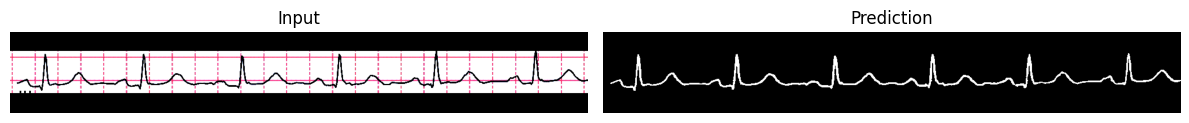

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


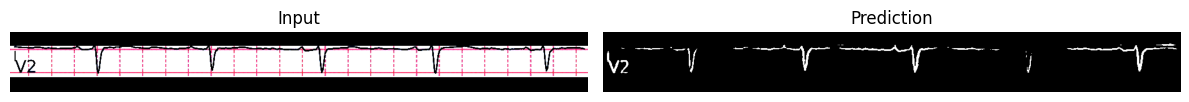

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


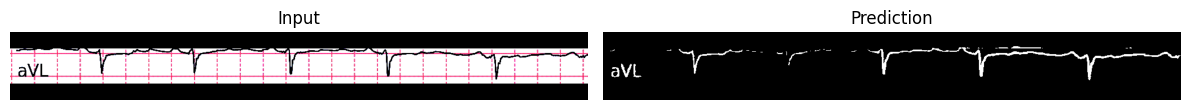

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


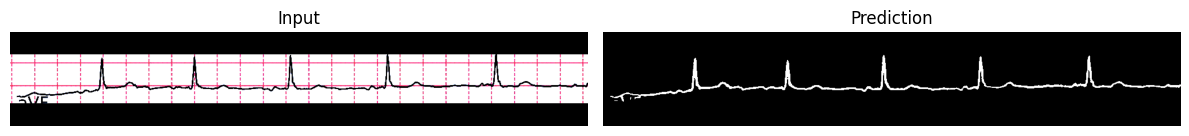

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


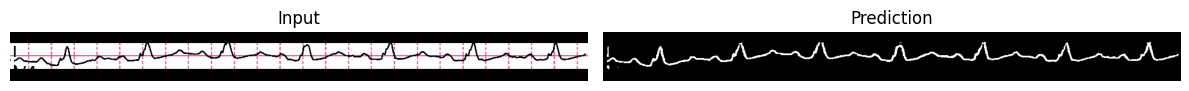

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


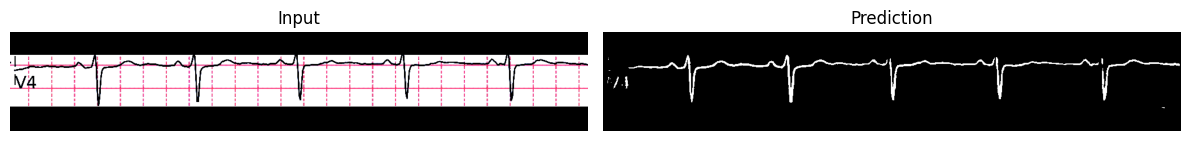

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


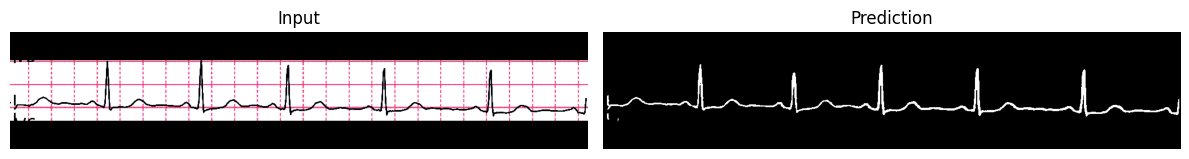

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


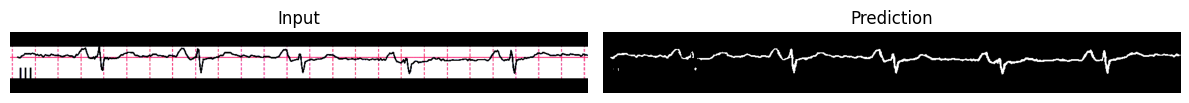

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


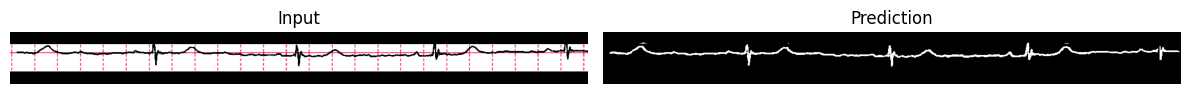

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


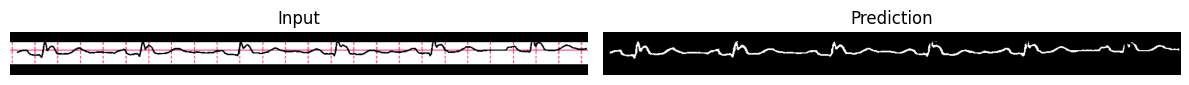

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


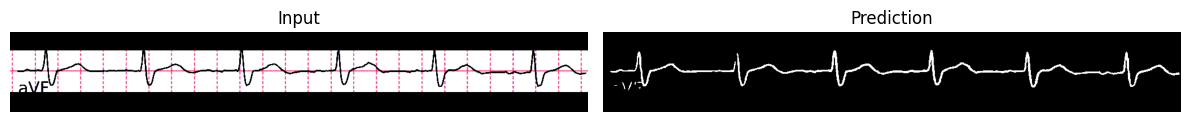

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


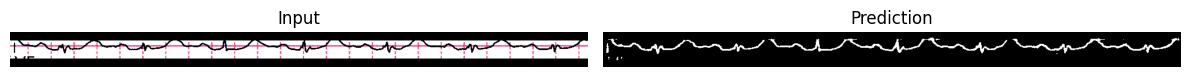

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


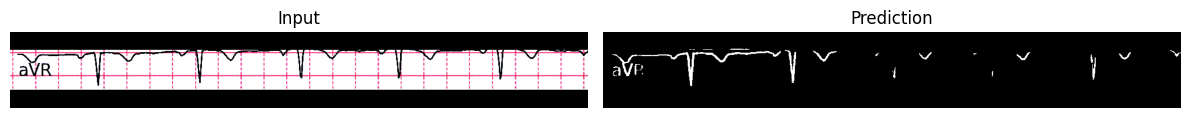

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


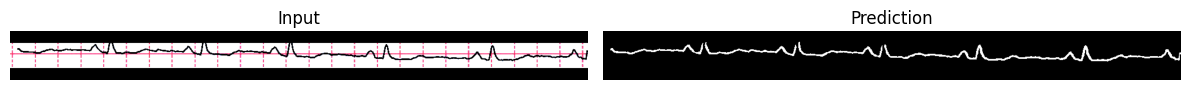

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


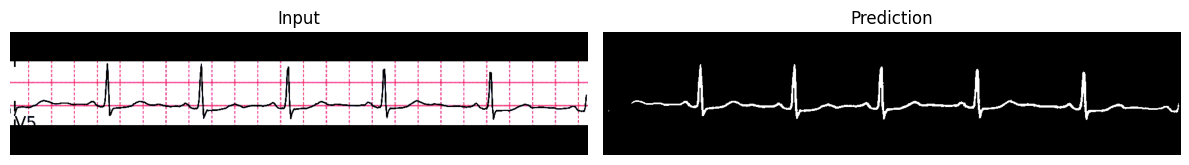

In [14]:
waves = []
# ---- Visualize & Save Predictions ----
def center_crop(tensor, target_h):
    # tensor shape: [C, H, W]
    _, h, w = tensor.shape
    top = (h - target_h) // 2
    return tensor[:, top:top+target_h, :]

def visualize_and_save_predictions(model, dataloader, device, save_dir="./unet_results/test_preds", num_images=10):
    os.makedirs(save_dir, exist_ok=True)
    images_shown = 0

    with torch.no_grad():
        for batch in dataloader:
            images, sizes = batch
            images = images.to(device)
            outputs = torch.sigmoid(model(images)) > 0.5

            for i in range(images.shape[0]):
                if images_shown >= num_images:
                    return

                h, w = sizes[0][0], sizes[1][0]  # Tuple
                h, w = int(h), int(w)

                input_img = center_crop(images[i].cpu(), h)
                pred_mask = center_crop(outputs[i].float().cpu(), h)
                waves.append(pred_mask)

                orig_name = os.path.basename(valid_images[images_shown])
                orig_base, orig_ext = os.path.splitext(orig_name)
                wave_mask_name = f"{orig_base}_wave{orig_ext if orig_ext.lower() in ['.jpg', '.jpeg', '.png'] else '.png'}"
                save_image(pred_mask, os.path.join(save_dir, wave_mask_name))
                
                # Optional plot
                fig, axs = plt.subplots(1, 2, figsize=(12, 4))
                axs[0].imshow(input_img.permute(1, 2, 0))
                axs[0].set_title("Input")
                axs[1].imshow(pred_mask[0], cmap="gray")
                axs[1].set_title("Prediction")
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                images_shown += 1

# === Run ===
visualize_and_save_predictions(model, test_loader, save_dir=SAVE_DIR, device="cpu", num_images=15)

# Convert the binary mask to a signal

In [22]:
import numpy as np
from scipy.interpolate import interp1d

def binary_mask_to_waveform(mask, square_size):
    """
    Converts a binary ECG mask to a 1D waveform array in mV, sampled at 0.01s intervals.
    Baseline is found using the mode of all y indices (your logic).
    """
    H, W = mask.shape

    # Calibration
    x_pixel_sec = 0.2 / square_size   # seconds per pixel (horizontal)
    y_pixel_mV  = 0.5 / square_size   # mV per pixel (vertical)

    # For each column, get mean y of white pixels
    y_means = np.full(W, np.nan)
    all_y_indices = []
    for x in range(W):
        y_indices = np.where(mask[:, x] > 0)[0]
        if len(y_indices) > 0:
            y_means[x] = y_indices.mean()
            all_y_indices.extend(y_indices.tolist())

    # --- Baseline logic exactly as you wrote ---
    # Build a histogram of all y indices (vertical axis)
    if len(all_y_indices) == 0:
        raise ValueError("No wave pixels found in mask.")
    counts = np.bincount(all_y_indices, minlength=H)
    baseline_y = int(np.argmax(counts))

    # Amplitude: (y_baseline - y_mean) * y_pixel_mV
    amplitude_mv = (baseline_y - y_means) * y_pixel_mV
    # Above baseline: positive, below: negative

    # Time axis for original signal
    time = np.arange(W) * x_pixel_sec

    # Interpolate to 0.01s intervals
    time_interp = np.arange(0, time[-1], 0.0025)  # 0.0025s intervals (40Hz)
    valid = ~np.isnan(amplitude_mv)
    interp_func = interp1d(time[valid], amplitude_mv[valid], kind='linear', bounds_error=False, fill_value="extrapolate")
    signal_mv_interp = interp_func(time_interp)

    return signal_mv_interp, time_interp, baseline_y

In [23]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops

def clean_and_skeletonize_wave(mask, min_area=100, gap_threshold=5):
    """
    Cleans and skeletonizes the binary ECG wave mask.
    Also connects vertically aligned segments and retains only the largest component.

    Args:
        mask (np.ndarray): Binary mask [H, W], wave = 1 or 255
        min_area (int): Minimum area to keep connected components.
        gap_threshold (int): Max vertical distance between centers to consider them aligned.

    Returns:
        np.ndarray: Skeletonized binary mask with only the main wave [H, W]
    """

    # Step 1: Remove small regions
    labeled = label(mask)
    cleaned = np.zeros_like(mask)
    regions = [r for r in regionprops(labeled) if r.area >= min_area]
    for r in regions:
        for y, x in r.coords:
            cleaned[y, x] = 1

    # Step 2: Attempt to connect vertically aligned components
    centers = [(int(r.centroid[0]), int(r.centroid[1])) for r in regions]
    for i in range(len(centers)):
        for j in range(i + 1, len(centers)):
            y1, x1 = centers[i]
            y2, x2 = centers[j]
            if abs(x1 - x2) <= 1 and abs(y1 - y2) <= gap_threshold:
                # Draw line to connect components
                cv2.line(cleaned, (x1, y1), (x2, y2), 1, 1)

    # Step 3: Skeletonize
    # skeleton = skeletonize(cleaned.astype(bool)).astype(np.uint8)

    # Step 4: Keep only the largest connected component (assumed to be the main wave)
    labeled_skel = label(cleaned)
    props = regionprops(labeled_skel)

    if not props:
        return np.zeros_like(mask, dtype=np.uint8)

    largest = max(props, key=lambda x: x.area)
    final = np.zeros_like(mask, dtype=np.uint8)
    for y, x in largest.coords:
        final[y, x] = 255

    return final


In [24]:
len(waves)

15

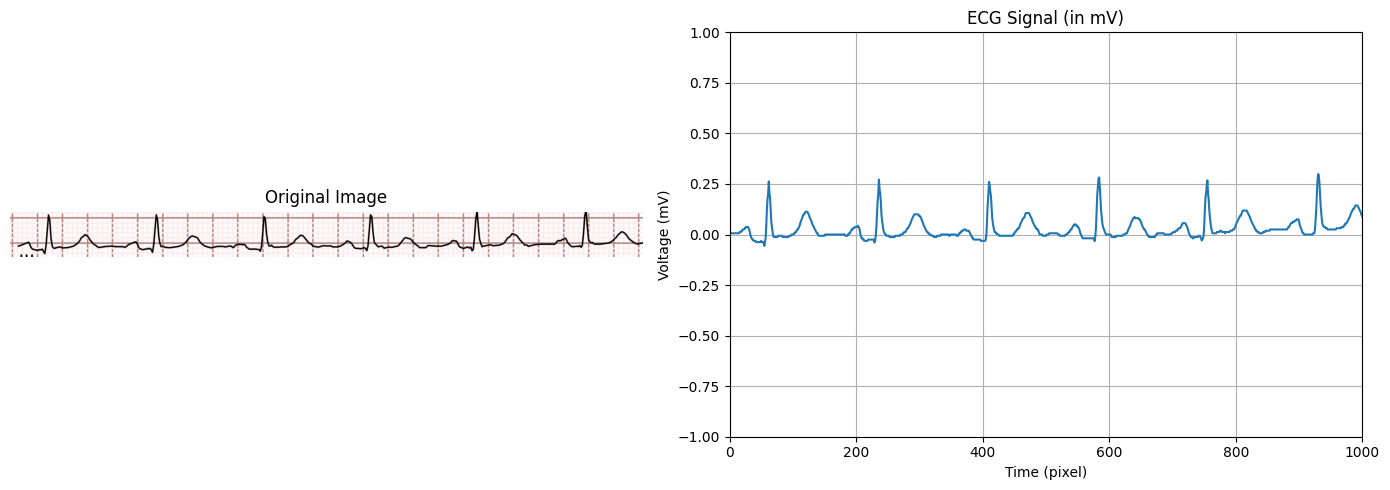

Length: 1023  Min: -0.05625  Max: 0.2989583333333334 Mean: 0.02789790778014752


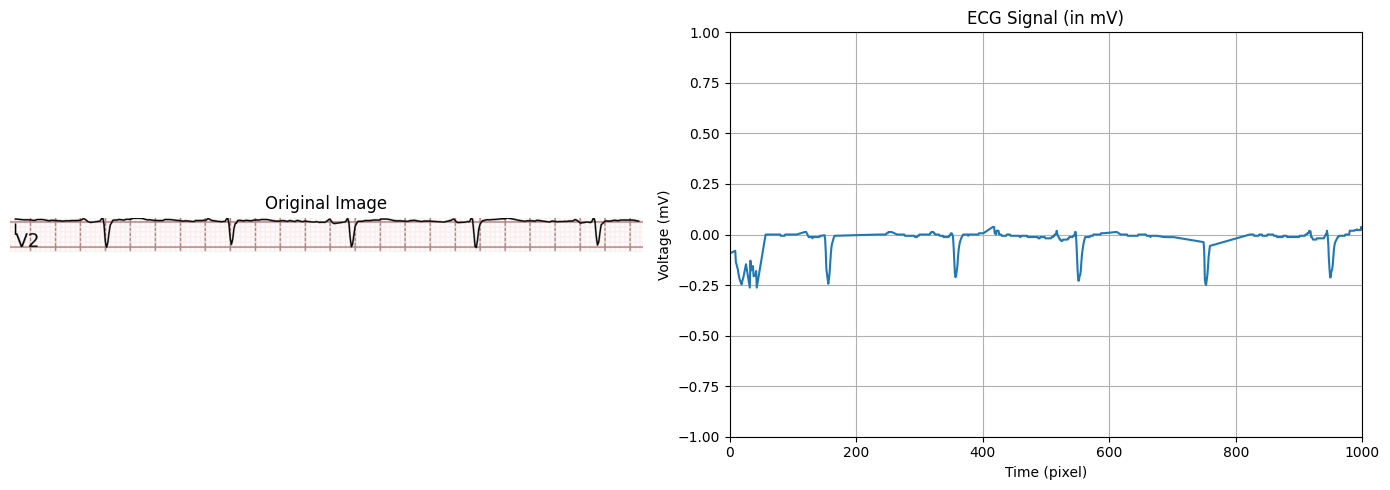

Length: 1023  Min: -0.2625  Max: 0.037500000000000006 Mean: -0.021893670947006727


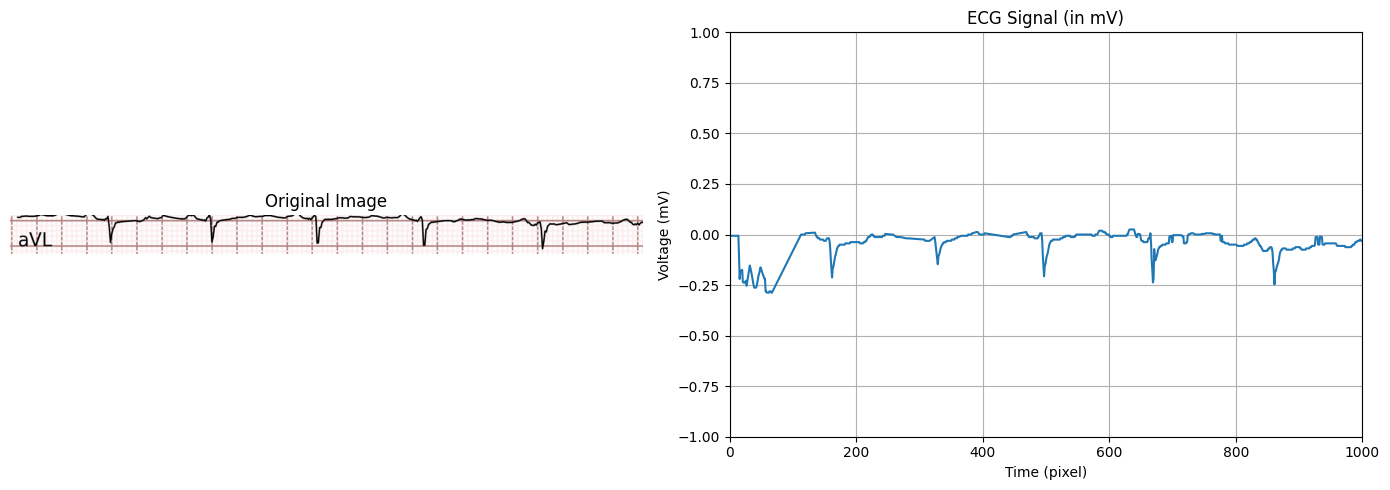

Length: 1023  Min: -0.28750000000000003  Max: 0.025 Mean: -0.0445218133121359


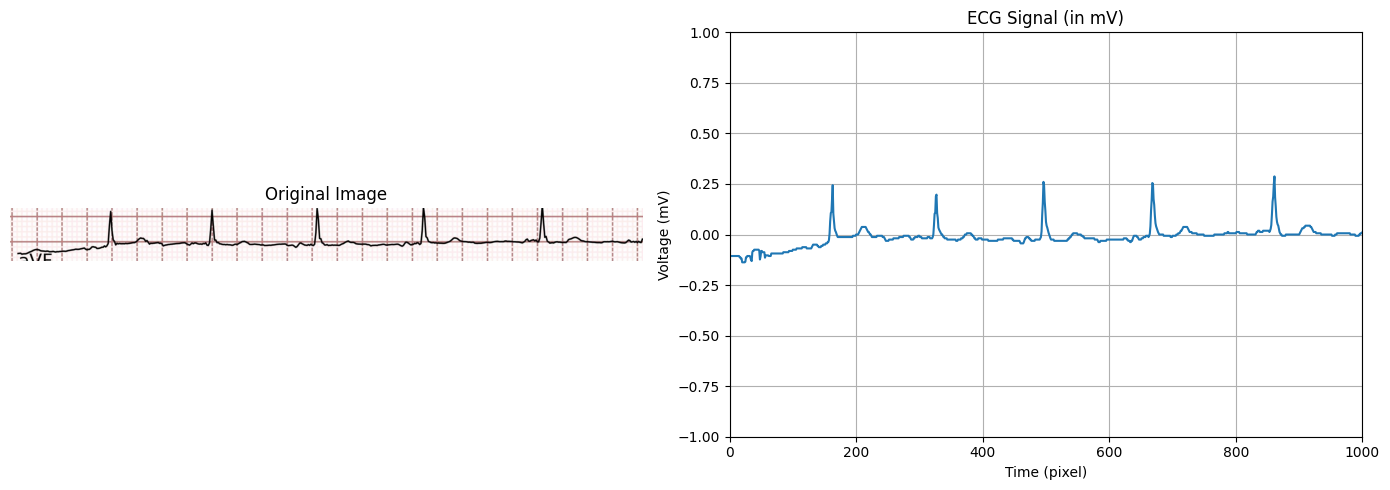

Length: 1023  Min: -0.1375  Max: 0.28750000000000003 Mean: -0.012959403908045673


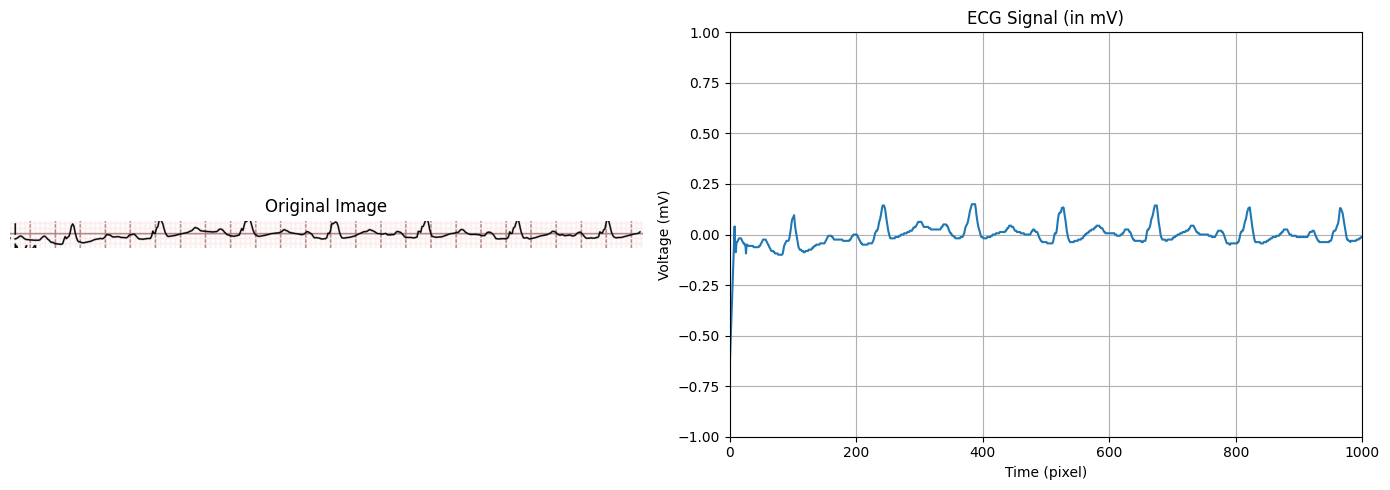

Length: 1023  Min: -0.6805147058823534  Max: 0.15000000000000002 Mean: -0.00397442762540011


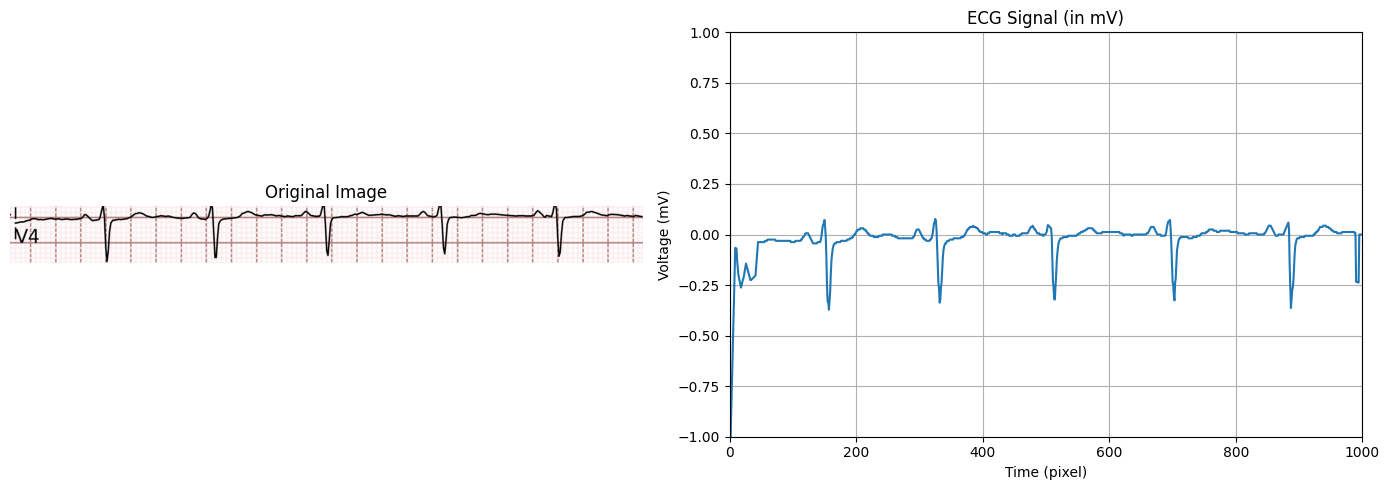

Length: 1023  Min: -1.215178571428572  Max: 0.07708333333333335 Mean: -0.024039440322916692


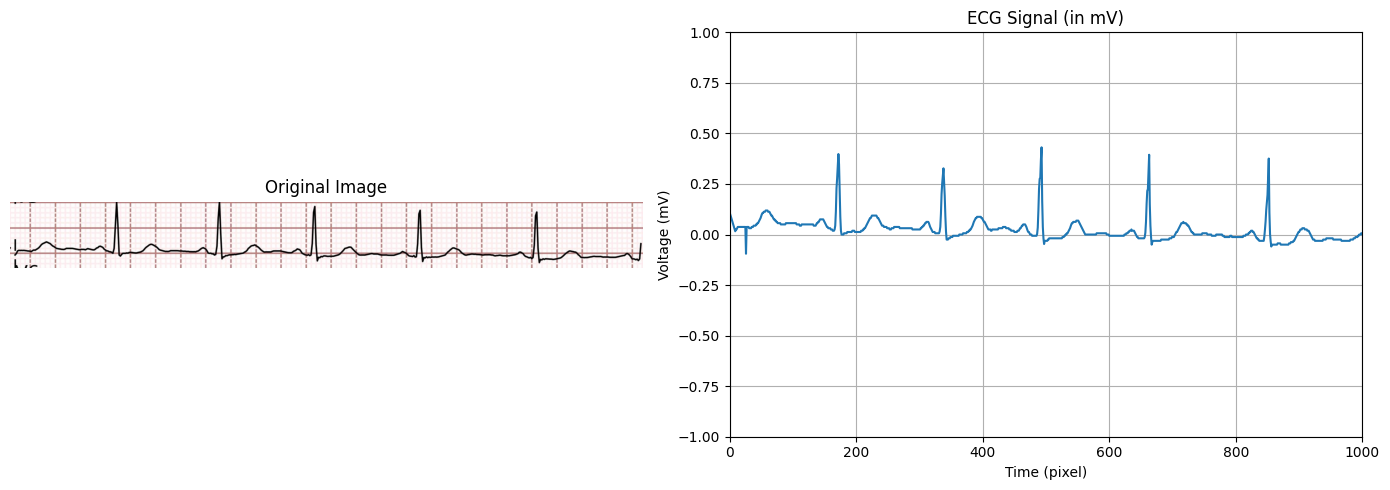

Length: 1023  Min: -0.09499999999999995  Max: 0.43125 Mean: 0.022710079784879746


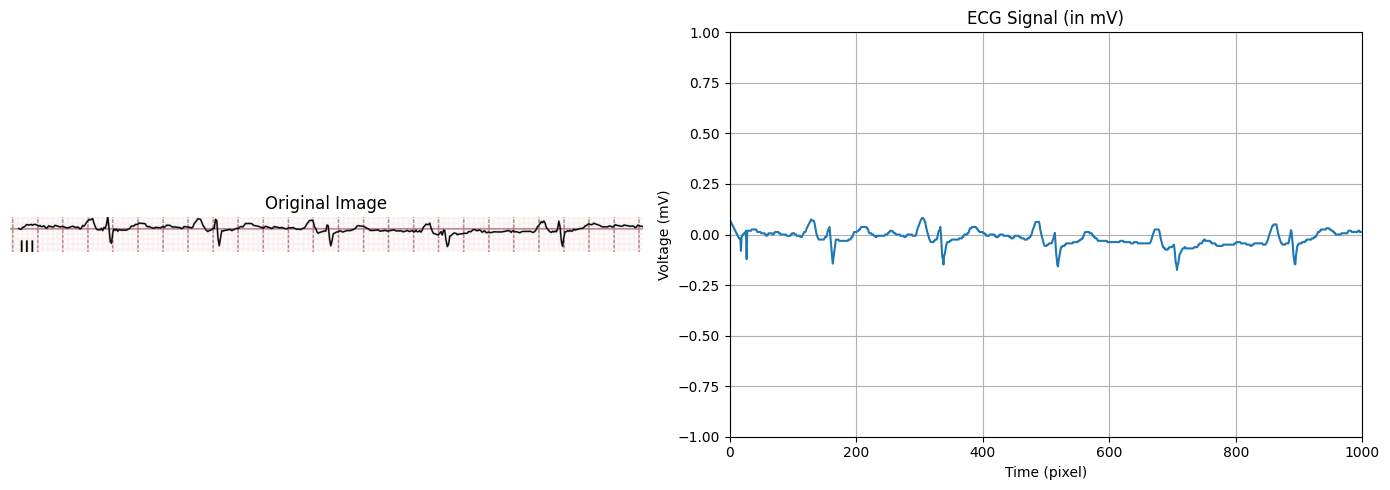

Length: 1023  Min: -0.17500000000000002  Max: 0.08125 Mean: -0.015726762986660345


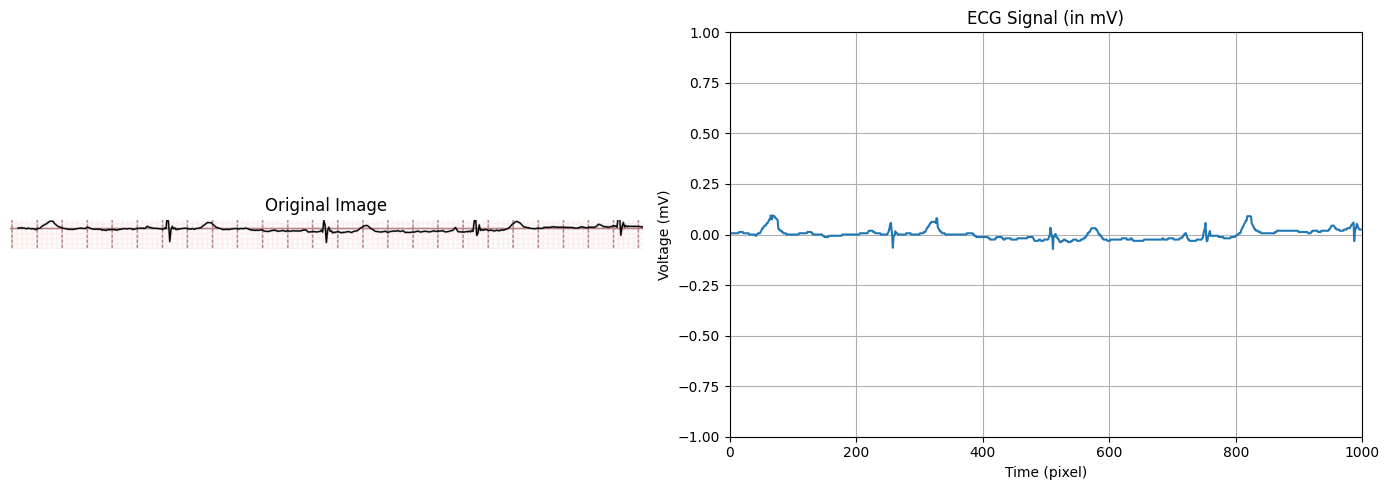

Length: 1023  Min: -0.07159090909090908  Max: 0.09375 Mean: 0.0015484491410077915


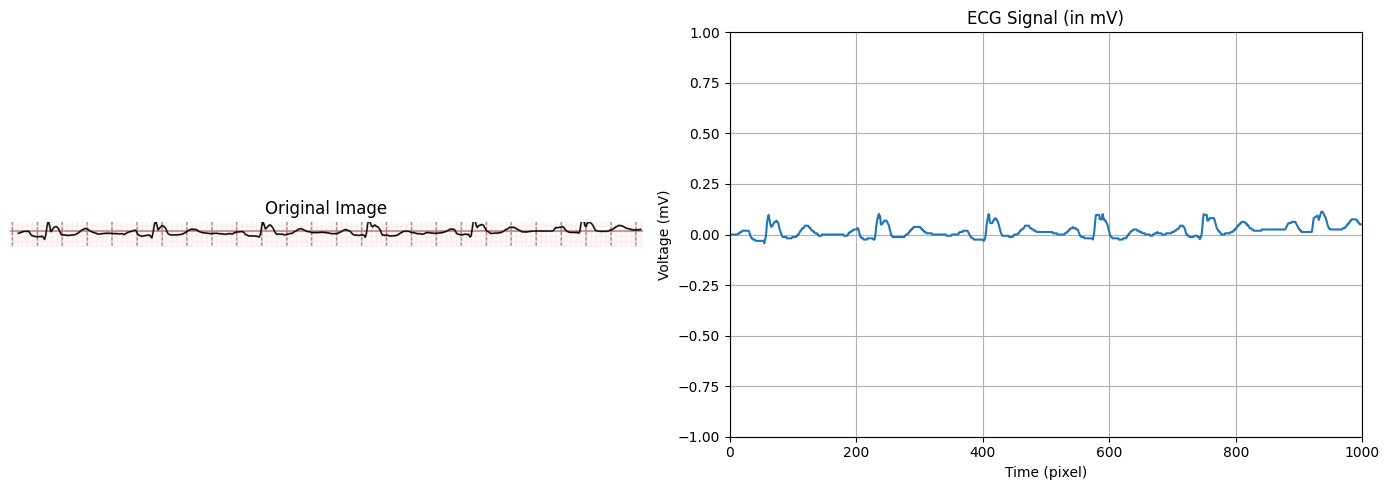

Length: 1023  Min: -0.043750000000000004  Max: 0.1125 Mean: 0.01845878136200717


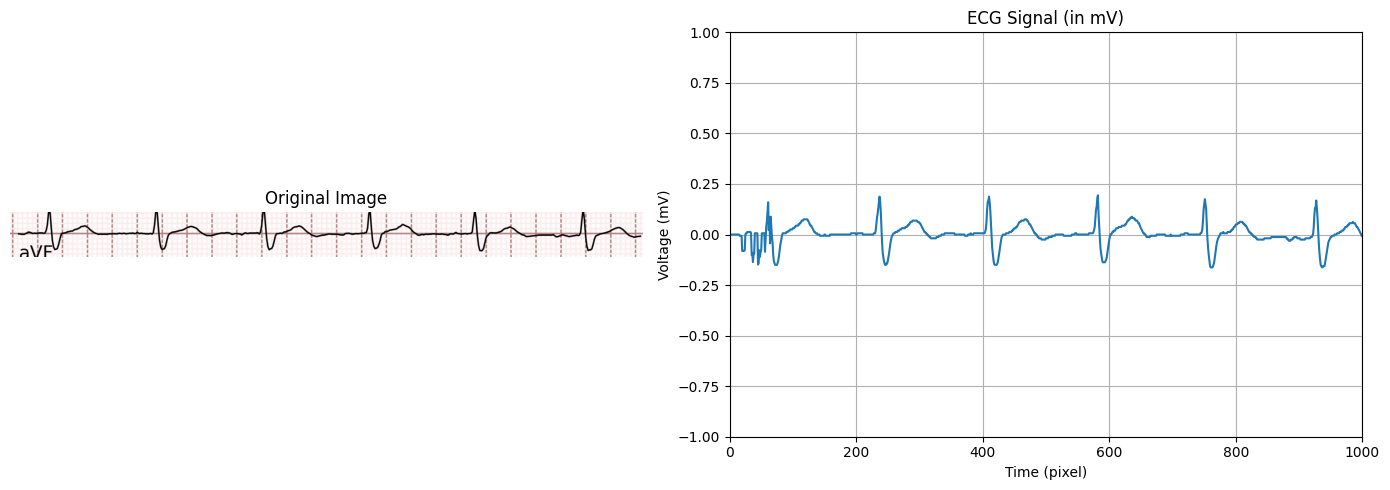

Length: 1023  Min: -0.1625  Max: 0.19375 Mean: 0.0013872648815830629


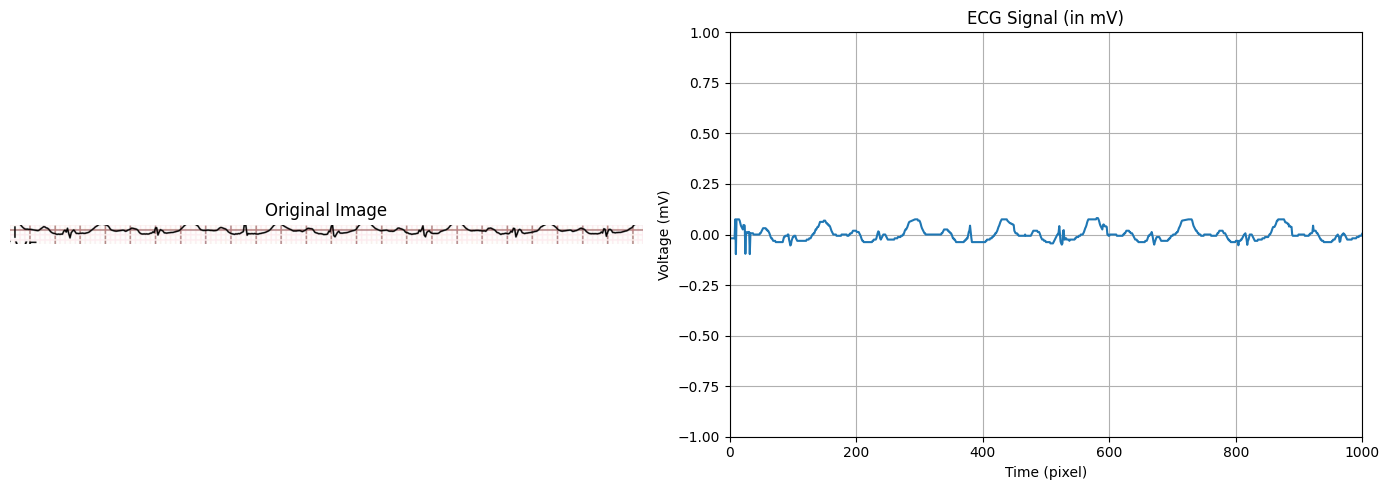

Length: 1023  Min: -0.09687500000000002  Max: 0.12500000000000222 Mean: 0.0026647814551040423


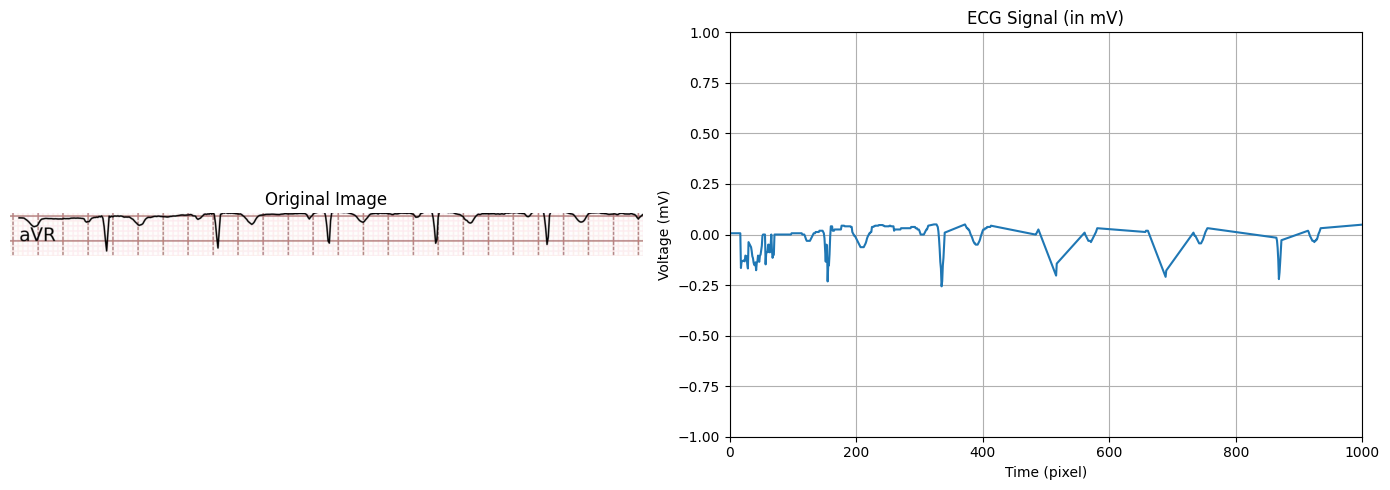

Length: 1023  Min: -0.25625000000000003  Max: 0.05 Mean: -0.008307130545950196


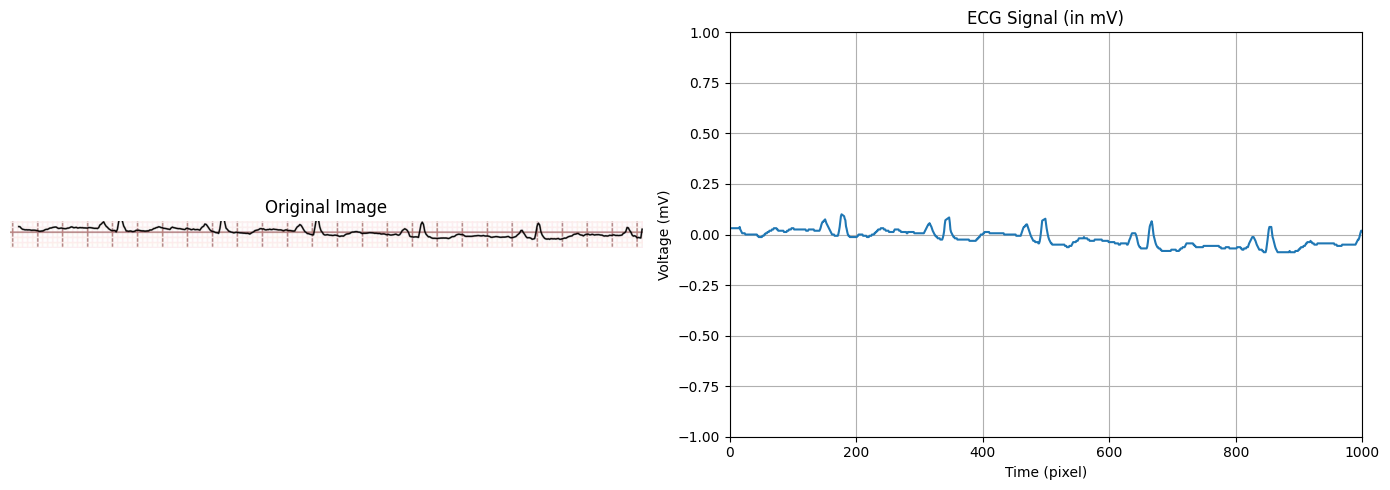

Length: 1023  Min: -0.08750000000000001  Max: 0.1 Mean: -0.01932164385793418


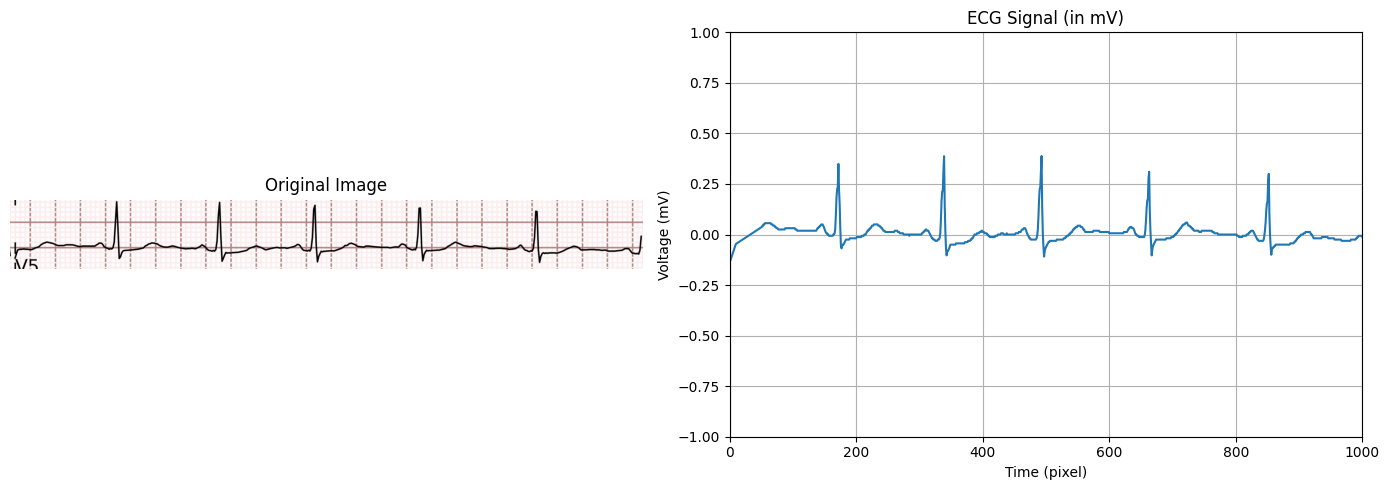

Length: 1023  Min: -0.14062499999999994  Max: 0.38828125 Mean: 0.003713220187120946


In [36]:
waveforms = []
for i in range(len(waves)):
    mask = waves[i]
    mask = (mask > 0.5).cpu().numpy().astype(np.uint8)
    mask = np.squeeze(mask)  # Remove channel dimension if present
    mask = skeletonize(mask.astype(bool)).astype(np.uint8)

    waveform,_,_ = binary_mask_to_waveform(mask, square_size=sizes[i])
    waveforms.append(waveform)
    
    # Use the original image name for consistent naming
    orig_name = os.path.basename(valid_images[i])
    orig_base, orig_ext = os.path.splitext(orig_name)

    # Load original image for plotting
    orig_img_path = os.path.join('../data/final-outputs', f"{orig_base}{orig_ext}")
    orig_img = cv2.imread(orig_img_path)
    if orig_img is not None:
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Plot original image and waveform side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    if orig_img is not None:
        axs[0].imshow(orig_img)
        axs[0].set_title("Original Image")
        axs[0].axis('off')
    else:
        axs[0].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axs[0].set_title("Original Image")
        axs[0].axis('off')

    # Set fixed x/y limits for all plots
    xlim = (0, 1000)   # adjust as needed for your data
    ylim = (-1, 1) # adjust as needed for your data (in mV)

    axs[1].plot(waveform)
    axs[1].set_title("ECG Signal (in mV)")
    axs[1].set_xlabel("Time (pixel)")
    axs[1].set_ylabel("Voltage (mV)")
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)
    axs[1].grid()
    plt.tight_layout()
    plt.show()

    print(f"Length: {len(waveform)}", f" Min: {waveform.min()}", f" Max: {waveform.max()}", f"Mean: {waveform.mean()}")

    # # --- Save the plot ---
    # plot_path = os.path.join('../data/final-outputs', f"{orig_base}_waveform_plot.png")
    # fig.savefig(plot_path)
    # plt.close(fig)

    # # --- Save the waveform array ---
    # npy_path = os.path.join('../data/final-outputs', f"{orig_base}_wave.npy")
    # np.save(npy_path, waveform)

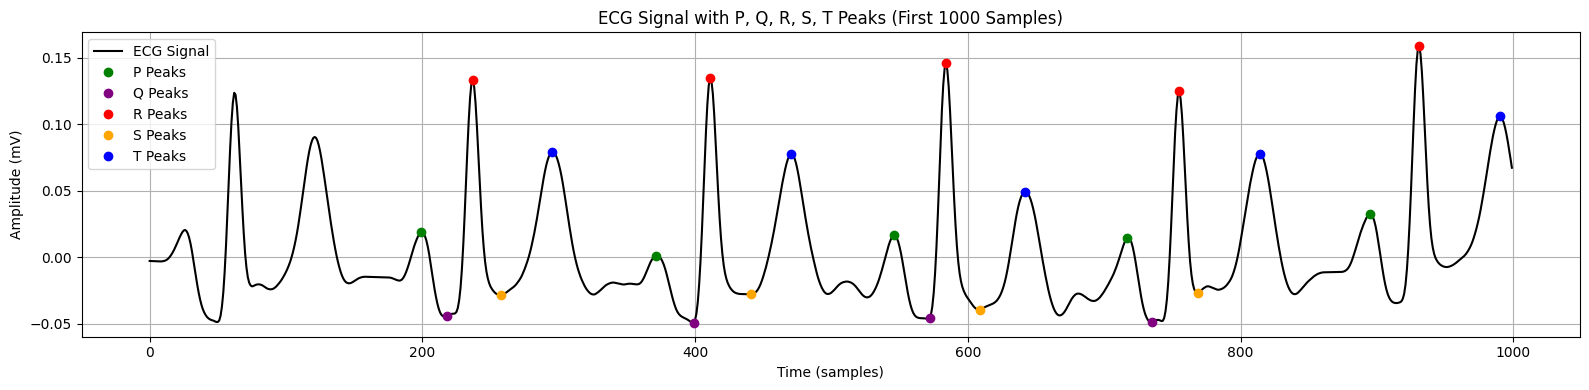

In [60]:
import neurokit2 as nk

# --- Load ECG waveform ---
npy_path = "../data/final-outputs/1110_6by2_II_wave.npy"  # change this as needed
signal = np.load(npy_path)

pad_len = 4000 - len(signal)
signal2 = np.pad(signal, (0, pad_len), mode='constant')

signals, info = nk.ecg_process(signal2, sampling_rate=400)


# Plot the cleaned ECG signal up to 1000 samples
plt.figure(figsize=(16, 4))
plt.plot(signals["ECG_Clean"][:1000], label="ECG Signal", color="black")

# Plot the P, Q, R, S, T peaks within the first 1000 samples
colors = {
    "P": "green",
    "Q": "purple",
    "R": "red",
    "S": "orange",
    "T": "blue"
}

for wave, color in colors.items():
    peaks = signals[f"ECG_{wave}_Peaks"]
    peak_indices = np.where(peaks == 1)[0]
    peak_indices = peak_indices[peak_indices < 1000]  # Keep only peaks within first 1000
    plt.plot(peak_indices, signals["ECG_Clean"].iloc[peak_indices], 'o', label=f"{wave} Peaks", color=color)

plt.title("ECG Signal with P, Q, R, S, T Peaks (First 1000 Samples)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

